In [1]:
import torch 
from torch import nn, Tensor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 20*2, h: int = 64*2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            # nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    # Batch-aware forward call
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        t = t.view(-1, 1)
        x_t = x_t.view(-1, 20*2)
        net_out = self.net(torch.cat((t, x_t), -1))
        return net_out.view((-1, 20, 2))

    # ODE-solve step for sampling
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:      
        t_start = t_start.view(1, 1, 1).expand(x_t.shape[0], 1, 1)

        # Midpoint method with Delta t = t_end - t_start
        mid_t = t_start + (t_end - t_start) / 2
        mid_x = x_t + self(x_t=x_t, t= t_start) * (t_end - t_start) / 2
        out_net = x_t + self(x_t=mid_x, t=mid_t) * (t_end - t_start)

        return out_net


# Training

In [3]:
## Do everything on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

flow = Flow().to(device)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

# all_data = np.load('data/lotka-volterra-train.npz')['X']
all_data = np.load('data/train_data.npz')['X']
print(all_data.shape)

for it in range(500000):
    x_1 = Tensor(all_data[it%1]).to(device)
    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(len(x_1), 1, 1).to(device)

    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

(1, 5000, 20, 2)


# Sampling

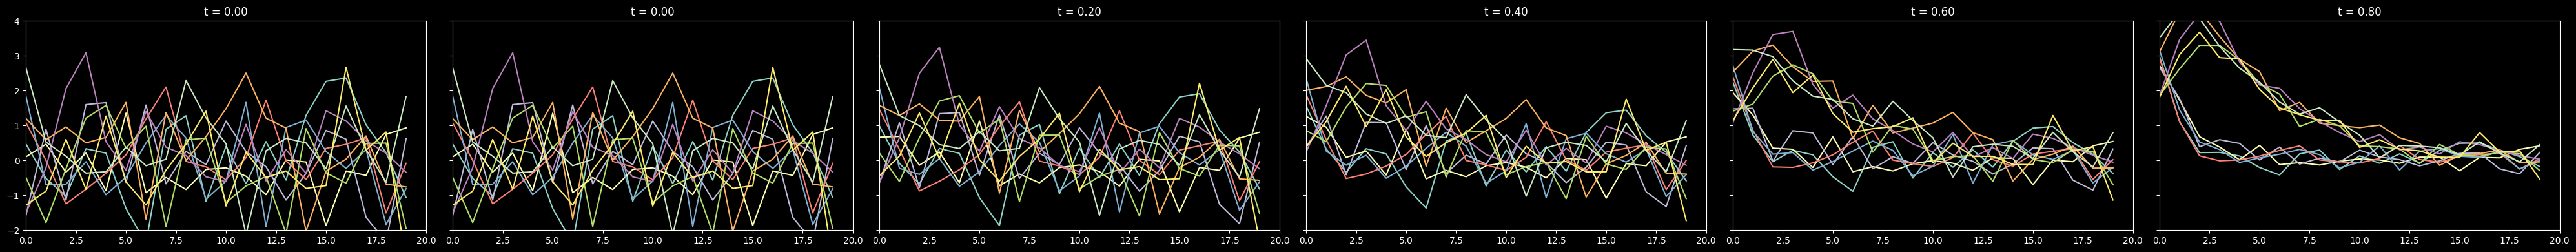

In [5]:
x = torch.randn(5, 20, 2)
n_steps = 500000
n_plots = 5
fig, axes = plt.subplots(1, n_plots + 1, figsize=(8*n_plots, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

x = x.view((-1, 20, 2))
axes[0].plot(x[:, :, 0].T.cpu().detach())
axes[0].plot(x[:, :, 1].T.cpu().detach())
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-0.0, 20.0)
axes[0].set_ylim(-2.0, 4.0)

x = x.to(device)
# flow.eval()

with torch.no_grad():
    for i in range(n_steps):
        x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
        x = x.view((-1, 20, 2))
        # axes[i + 1].scatter(x[:, 0], x.detach()[:, 1], s=10)

        if i % (n_steps // n_plots) == 0:
            ax_id = i // (n_steps // n_plots) + 1
            axes[ax_id].plot(x[:, :, 0].T.cpu().detach())
            axes[ax_id].plot(x[:, :, 1].T.cpu().detach())
            axes[ax_id].set_title(f't = {time_steps[i + 1]:.2f}')

    # torch.cuda.empty_cache()

plt.tight_layout()
plt.show()